# Objective

- Perform Monte Carlo simulations for the estimation of a Spatial Lag model using the ML estimation method from spreg
- Check the properties of the estimators


In [1]:
import numpy as np
import pysal as ps
import numpy.linalg as la
import seaborn as sns
import matplotlib.pyplot as plt
import spreg
import time

C:\Users\renan\.conda\envs\base3\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\renan\.conda\envs\base3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\renan\.conda\envs\base3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## Define functions

In [2]:
def wtransform(u,w,rho):
    """wtransform: spatial autoregressive transformation
    arguments:
    u: vector to be transformed
    w: spatial weights matrix as full matrix
    rho: spatial autoregressive coefficient
    returns:
    v: spatially transformed vector
    """
    n = len(u)
    irw = np.eye(n) - rho * w # (I-pW)
    irwi = la.inv(irw) #(i-pW)^-1
    v = np.dot(irwi,u)
    return v

In [3]:
def sarlag(xb,w,rho,sigma):
    """sarlag: generates y for spatial lag process with given xbeta, W, rho
    and sigma for the error term
    arguments:
    xb: vector with product of x matrix and beta vector
    w: spatial weights matrix as full matrix
    rho: spatial autoregressive coefficient
    returns:
    y: vector of observations on dependent variable
    """
    n = len(xb)
    u = np.array( [rnd.gauss(0,sigma) for r in range(n)]).reshape(n,1)
    v = wtransform(u,w,rho)
    wxb = wtransform(xb,w,rho)
    y = wxb + v
    return y

## 1. Single estimation

We generate some data from a Spatial Lag process with a single independent variable, the DGP is: $$ y=(I-\rho W)^{-1}X\beta+(I-\rho W)^{-1}\epsilon$$

In [4]:
#Error term
n = 25
sigma = 10.0
u = np.random.normal(scale=sigma, size=n).reshape(n,1)

#Spatial Weights matrix
w = ps.lib.weights.lat2W(5,5) # Rook matrix for a 5x5 grid
w.transform = 'r' #Row-standardize it
bigw = ps.lib.weights.full(w)[0] #Transform into matrix form
#Constructing X (from random draws) for the regression

unib = 100
x1 = np.random.uniform(0,unib, size=n).reshape(n,1)
x = np.hstack((np.ones((n,1)),x1))
betapar = 1.0
beta = np.array([1.0, betapar]).reshape(2,1)
xb = np.dot(x,beta)


In [5]:
#Dependent variable
rho=0.5
y2 = sarlag(xb,bigw,rho,sigma)

In [6]:
#Estimation
model=spreg.ML_Lag(y2,x1,w=w, name_x=['var1'])
print(model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:          25
Mean dependent var  :    101.2887                Number of Variables   :           3
S.D. dependent var  :     37.7209                Degrees of Freedom    :          22
Pseudo R-squared    :      0.9103
Spatial Pseudo R-squared:  0.7950
Sigma-square ML     :     122.853                Log likelihood        :     -97.301
S.E of regression   :      11.084                Akaike info criterion :     200.602
                                                 Schwarz criterion     :     204.259

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

C:\Users\renan\.conda\envs\base3\lib\site-packages\spreg\user_output.py:469: UserWarning: w must be API-compatible pysal weights object
  warn("w must be API-compatible pysal weights object")
C:\Users\renan\.conda\envs\base3\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [7]:
#Estimation
model=spreg.ML_Lag(y2,x1,w=w)
print(model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:          25
Mean dependent var  :    101.2887                Number of Variables   :           3
S.D. dependent var  :     37.7209                Degrees of Freedom    :          22
Pseudo R-squared    :      0.9103
Spatial Pseudo R-squared:  0.7950
Sigma-square ML     :     122.853                Log likelihood        :     -97.301
S.E of regression   :      11.084                Akaike info criterion :     200.602
                                                 Schwarz criterion     :     204.259

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

## 2. Monte Carlo Simulations

- Repeat previous step 1000 times, store the results and assess the properties

In [8]:
t0 = time.time()
#Vectors to store results
constant=[]
x1_hat=[]
rho_hat=[]

##Set parameters
#Spatial weight matrix
n = 25
w = ps.lib.weights.lat2W(5,5) # Rook matrix for a 5x5 grid
w.transform = 'r' #Row-standardize it
bigw = ps.lib.weights.full(w)[0] #Transform into matrix form

#Parameters for x, rho and u
sigma = 10.0
unib = 100
betapar = 3.0
beta = np.array([1, betapar]).reshape(2,1)
rho=0.7

#Simulations
for i in range(1000):
    u = np.random.normal(scale=sigma,size=n).reshape(n,1)
    x1 = np.random.uniform(0,unib, size=n).reshape(n,1)
    x = np.hstack((np.ones((n,1)),x1))
    xb = np.dot(x,beta)
    y2 = sarlag(xb,bigw,rho,sigma)
    model=spreg.ML_Lag(y2,x1,w=w, name_x=['var_1'])
    constant.append(model.betas[0]) #Estimate of the constant
    x1_hat.append(model.betas[1])   #Estimate of betapar
    rho_hat.append(model.betas[2])  #Estimate of rho
t1 = time.time()
print(t1-t0)
print('Constant:',sum(constant)/len(constant))
print('X1:',sum(x1_hat)/len(x1_hat))
print('rho:',sum(rho_hat)/len(rho_hat))
    

14.790403366088867
Constant: [3.78653727]
X1: [3.00118702]
rho: [0.69404991]


### 2.1 Checking Unbiasedness

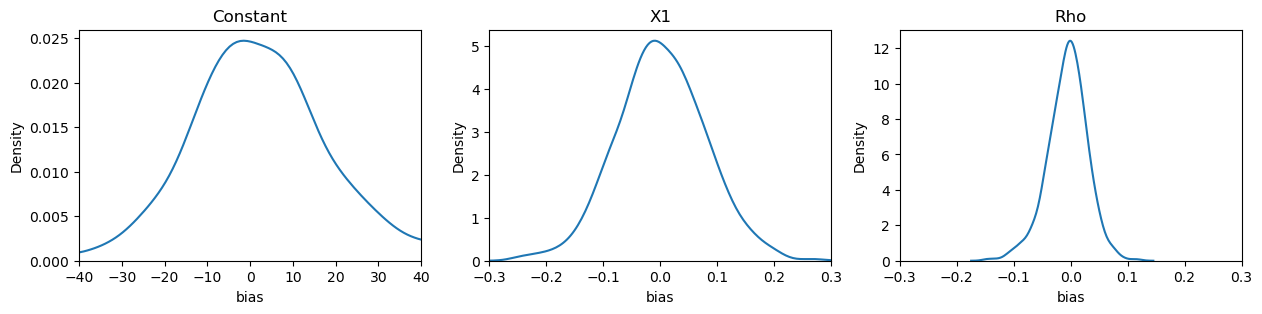

In [9]:
fig,axes=plt.subplots(1,3, figsize=(15,3))
sns.kdeplot(np.array(constant)-1,ax=axes[0], legend=False)
axes[0].set(xlabel='bias', title='Constant', xlim=(-40,40))
sns.kdeplot(np.array(x1_hat)-betapar,ax=axes[1], legend=False)
axes[1].set(xlabel='bias', title='X1', xlim=(-0.3,0.3))
sns.kdeplot(np.array(rho_hat)-rho,ax=axes[2], legend=False)
axes[2].set(xlabel='bias', title='Rho', xlim=(-0.3,0.3));

**Notes**
- The estimators for x1 and rho seems to be unbiased
- The estimation of the constant seems to be a bit biased and with very large variance. Too small sample size?

### 2.2 Checking consistency 

- Run simulations increasing the sample size and check the behavior of the estimator

In [10]:
t0 = time.time()

#Parameters for x, rho and u
sigma = 10.0
unib = 100
betapar = 3.0
beta = np.array([1, betapar]).reshape(2,1)
rho=0.7
samples=[16,49,144,529]
#Dictionaries to store results
Constant={}
X1_hat={}
Rho_hat={}

for j in range(4):
    #Vectors to store results
    constant=[]
    x1_hat=[]
    rho_hat=[]

    ##Set parameters
    #Spatial weight matrix
    n = samples[j]
    n1=np.sqrt(n).astype(int)
    w = ps.lib.weights.lat2W(n1,n1) # Rook matrix for a regular grid
    w.transform = 'r' #Row-standardize it
    bigw = ps.lib.weights.full(w)[0] #Transform into matrix form


    #Simulations
    for i in range(1000):
        u = np.random.normal(scale=sigma,size=n).reshape(n,1)
        x1 = np.random.uniform(0,unib, size=n).reshape(n,1)
        x = np.hstack((np.ones((n,1)),x1))
        xb = np.dot(x,beta)
        y2 = sarlag(xb,bigw,rho,sigma)
        model=spreg.ML_Lag(y2,x1,w=w, name_x=['var_1'])
        constant.append(model.betas[0]) #Estimate of the constant
        x1_hat.append(model.betas[1])   #Estimate of betapar
        rho_hat.append(model.betas[2])  #Estimate of rho
    t1 = time.time()
    print(t1-t0)
    Constant[j]=constant
    X1_hat[j]= x1_hat
    Rho_hat[j]= rho_hat
for j in range(4):
    print('Constant_n=',samples[j],sum(Constant[j])/len(Constant[j]))
    print('X1_n=',samples[j],sum(X1_hat[j])/len(X1_hat[j]))
    print('Rho_n=',samples[j],sum(Rho_hat[j])/len(Rho_hat[j]))

C:\Users\renan\.conda\envs\base3\lib\site-packages\spreg\user_output.py:469: UserWarning: w must be API-compatible pysal weights object
  warn("w must be API-compatible pysal weights object")
C:\Users\renan\.conda\envs\base3\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


14.460919618606567
33.65609645843506
70.86617684364319
426.1768424510956
Constant_n= 16 [7.27472312]
X1_n= 16 [2.9980981]
Rho_n= 16 [0.68744697]
Constant_n= 49 [1.78802225]
X1_n= 49 [3.00210428]
Rho_n= 49 [0.69840559]
Constant_n= 144 [1.52436202]
X1_n= 144 [2.99934743]
Rho_n= 144 [0.69902839]
Constant_n= 529 [1.20584707]
X1_n= 529 [3.00034158]
Rho_n= 529 [0.69956264]


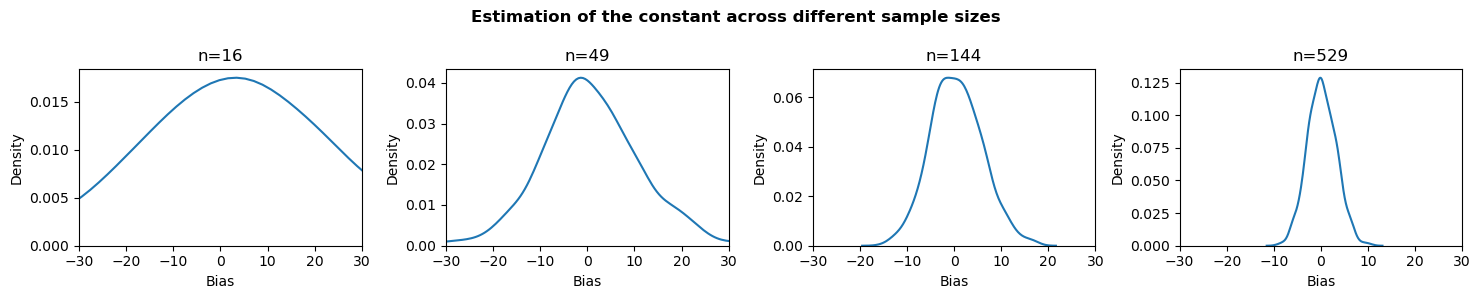

In [19]:
fig,axes=plt.subplots(1,4, figsize=(15,3))
fig.suptitle ('Estimation of the constant across different sample sizes', fontweight="bold")
for i in range(4):
    sns.kdeplot(np.array(Constant[i])-1,ax=axes[i], legend=False)
    axes[i].set(xlabel='Bias', title=f'n={samples[i]}', xlim=(-30,30))
fig.tight_layout();

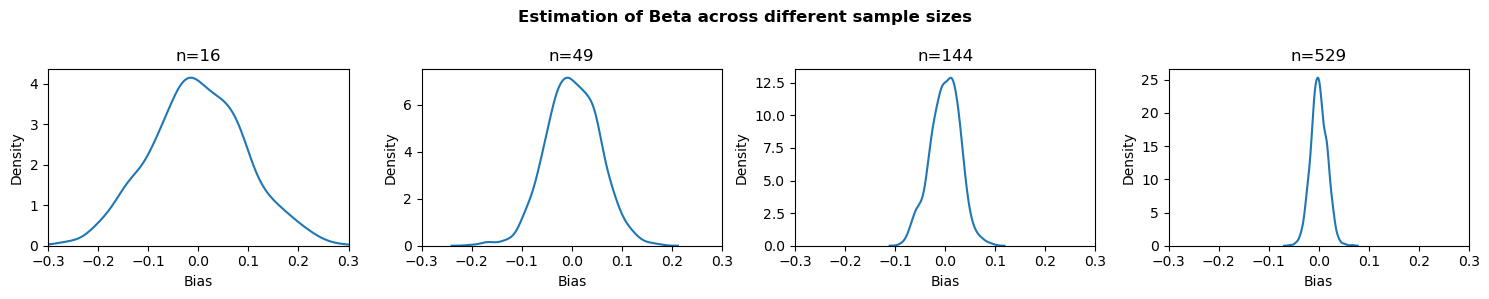

In [17]:
fig,axes=plt.subplots(1,4, figsize=(15,3))
fig.suptitle ('Estimation of Beta across different sample sizes', fontweight="bold")
for i in range(4):
    sns.kdeplot(np.array(X1_hat[i])-betapar,ax=axes[i], legend=False)
    axes[i].set(xlabel='Bias', title=f'n={samples[i]}', xlim=(-0.3,0.3))
fig.tight_layout();

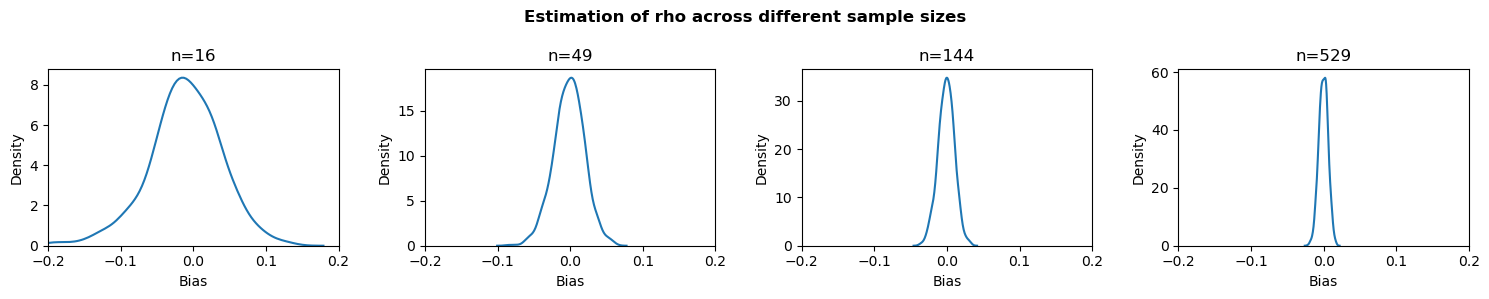

In [16]:
fig,axes=plt.subplots(1,4, figsize=(15,3))
fig.suptitle ('Estimation of rho across different sample sizes', fontweight="bold")
for i in range(4):
    sns.kdeplot(np.array(Rho_hat[i])-rho,ax=axes[i], legend=False)
    axes[i].set(xlabel='Bias', title=f'n={samples[i]}', xlim=(-0.2,0.2))
fig.tight_layout();

**Note:**
- As the sample size grows, the likelihood of observing estimates close to the true value increases